In [22]:
import tensorflow as tf
from keras.optimizer_v1 import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [23]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]


In [24]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input

In [25]:
orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
LEARN_RATE = 0.0001
OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'


In [26]:
BATCH_SIZE = 32

EPOCHS = 100

In [27]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = 'C:\\Users\\Ali\Documents\\minipigs_cropped_images\\Split_Data\\train'

# path to VALIDATE dataset of the OCT images
VALID_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\val'

# path to TESTING dataset of the OCT images
TEST_PATH = 'C:\\Users\\Ali\\Documents\\minipigs_cropped_images\\Split_Data\\test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [28]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-6]:
    layer.trainable = False

In [29]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [30]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.1)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [31]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [32]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [34]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 229 images belonging to 5 classes.


In [35]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [36]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 60 images belonging to 5 classes.


In [37]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 35 images belonging to 5 classes.


In [38]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

Epoch 1/100
8/8 [==============================] - 40s 4s/step - loss: 3.0392 - accuracy: 0.1747 - val_loss: 2.1520 - val_accuracy: 0.2167
Epoch 2/100
8/8 [==============================] - 24s 3s/step - loss: 2.2272 - accuracy: 0.2620 - val_loss: 1.9960 - val_accuracy: 0.3000
Epoch 3/100
8/8 [==============================] - 25s 3s/step - loss: 1.9401 - accuracy: 0.3013 - val_loss: 1.5604 - val_accuracy: 0.3500
Epoch 4/100
8/8 [==============================] - 23s 3s/step - loss: 2.0249 - accuracy: 0.3624 - val_loss: 1.7296 - val_accuracy: 0.3833
Epoch 5/100
8/8 [==============================] - 32s 4s/step - loss: 1.6633 - accuracy: 0.4410 - val_loss: 1.4753 - val_accuracy: 0.5333
Epoch 6/100
8/8 [==============================] - 29s 4s/step - loss: 1.5923 - accuracy: 0.4192 - val_loss: 1.6207 - val_accuracy: 0.4000
Epoch 7/100
8/8 [==============================] - 31s 4s/step - loss: 1.5137 - accuracy: 0.4279 - val_loss: 1.5301 - val_accuracy: 0.3500
Epoch 8/100
8/8 [==========

8/8 [==============================] - 37s 5s/step - loss: 0.8176 - accuracy: 0.7293 - val_loss: 1.0290 - val_accuracy: 0.6667
Epoch 60/100
8/8 [==============================] - 34s 4s/step - loss: 0.7360 - accuracy: 0.7074 - val_loss: 0.8889 - val_accuracy: 0.6667
Epoch 61/100
8/8 [==============================] - 36s 4s/step - loss: 0.8826 - accuracy: 0.7074 - val_loss: 0.8523 - val_accuracy: 0.7333
Epoch 62/100
8/8 [==============================] - 41s 5s/step - loss: 0.6487 - accuracy: 0.7773 - val_loss: 1.1165 - val_accuracy: 0.6333
Epoch 63/100
8/8 [==============================] - 42s 5s/step - loss: 0.7108 - accuracy: 0.6987 - val_loss: 0.9075 - val_accuracy: 0.6500
Epoch 64/100
8/8 [==============================] - 38s 5s/step - loss: 0.7611 - accuracy: 0.7162 - val_loss: 1.0334 - val_accuracy: 0.7500
Epoch 65/100
8/8 [==============================] - 43s 5s/step - loss: 0.6880 - accuracy: 0.7336 - val_loss: 1.1263 - val_accuracy: 0.7000
Epoch 66/100
8/8 [===============

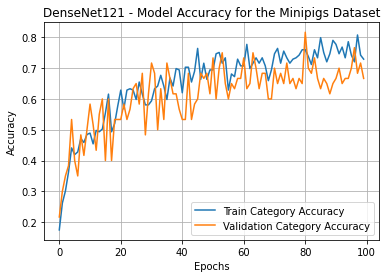

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

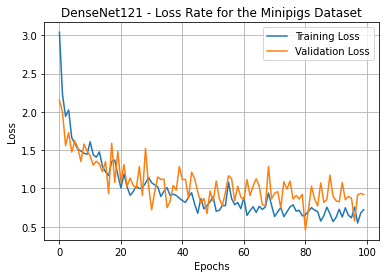

In [40]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [41]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 [==============================] - 6s 107ms/step - loss: 0.7769 - accuracy: 0.7333

Learn Rate = 0.0001 , Epochs = 100 , Training Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\train
Validation Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\val , Test Folder = C:\Users\Ali\Documents\minipigs_cropped_images\Split_Data\test

Training: 0.817, Validation: 0.733

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [42]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 [==============================] - 3s 27ms/step - loss: 0.6299 - accuracy: 0.7429

Test loss and accuracy are: [0.6298901438713074, 0.7428571581840515]
